In [1]:
import os
import GEOparse
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Import Data

In [2]:

def load_expression_matrix(filepath):
    data = GEOparse.get_GEO(filepath=filepath)
    full_df = data.table

    gsm_cols = [col for col in full_df.columns if col.startswith('GSM')]

    expr_df = (
        full_df
        .loc[:, ['IDENTIFIER'] + gsm_cols]
        .dropna(subset=['IDENTIFIER'])
        .set_index('IDENTIFIER')
    )

    expr_df = expr_df.apply(pd.to_numeric, errors='coerce')

    expr_df_collapsed = expr_df.groupby(expr_df.index).mean()

    return expr_df_collapsed.T
    

In [3]:

expr = load_expression_matrix("data/GDS4414_full.soft")
sample = expr.iloc[2]
sample.head()

21-Feb-2026 19:18:29 INFO GEOparse - Parsing data/GDS4414_full.soft: 
21-Feb-2026 19:18:29 DEBUG GEOparse - DATABASE: Geo
21-Feb-2026 19:18:29 DEBUG GEOparse - DATASET: GDS4414
21-Feb-2026 19:18:29 DEBUG GEOparse - SUBSET: GDS4414_1
21-Feb-2026 19:18:29 DEBUG GEOparse - SUBSET: GDS4414_2
21-Feb-2026 19:18:29 DEBUG GEOparse - SUBSET: GDS4414_3
21-Feb-2026 19:18:29 DEBUG GEOparse - SUBSET: GDS4414_4
21-Feb-2026 19:18:29 DEBUG GEOparse - SUBSET: GDS4414_5
21-Feb-2026 19:18:29 DEBUG GEOparse - SUBSET: GDS4414_6
21-Feb-2026 19:18:29 DEBUG GEOparse - ANNOTATION: 
21-Feb-2026 19:18:29 ERROR GEOparse - Cannot recognize type Annotation
21-Feb-2026 19:18:29 DEBUG GEOparse - DATASET: GDS4414
/opt/anaconda3/lib/python3.13/site-packages/GEOparse/GEOparse.py:401: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


IDENTIFIER
--Control        9.073441
0610005C13Rik    3.848540
0610006L08Rik    3.993080
0610007P14Rik    9.201110
0610009B22Rik    9.678720
Name: GSM636862, dtype: float64

# Sample Descriptive Statistics

In [4]:
class SampleProfile:
    def __init__(self, data):
        self.original = data
        self.array = self._to_numpy(data)
        self.stats = self._compute_stats()

    def _to_numpy(self, data):
        if isinstance(data, pd.Series):
            return data.to_numpy()
        elif isinstance(data, pd.DataFrame):
            if data.shape[0] == 1:
                return data.iloc[0].to_numpy()
            else:
                raise ValueError("DataFrame must contain exactly one row.")
        elif isinstance(data, np.ndarray):
            return data
        else:
            raise TypeError("Unsupported data type.")

    def _compute_stats(self):
        return {
            "mean": np.mean(self.array),
            "median": np.median(self.array),
            "std": np.std(self.array),
            "min": np.min(self.array),
            "max": np.max(self.array),
            "range": np.ptp(self.array),
            "variance": np.var(self.array)
        }


In [5]:
profile = SampleProfile(sample)
print(profile.stats["max"])
print(profile.stats["variance"])

14.171475000000001
4.947071670159146


# Adding in a Mutation

In [6]:
def mutation_generator(initial_row):
    """
    Creates an array the same size as input containing zeros except for one random position.

    Args:
        initial_row (binary list or np.array): one row containing expression data that has been MaxMin scaled, specified by user
        
    Returns:
        mutation (np.array): array of all zeros except for one random postion
    """
    # Initialize random generator 
    rng = np.random.default_rng()
    
    # Create an array of zeros that is the same shape as initial sample
    mutation_array = np.zeros_like(initial_row)
    
    # Define a random index to insert before, endpoint=True to allow inserting at end
    random_index = rng.integers(0, len(initial_row))
    mutation_value = rng.uniform(0, 1)
    mutation_array[random_index] = mutation_value

    return mutation_array
                                      

In [ ]:
initial_row = sample[0: 10]
mutation_generator(initial_row)

In [13]:
def genomic_sample_row_mutation(
    initial_row, 
    num_rows, 
    stat, 
    decay_scale, 
    mutation_frequency,
    mutation_intensity, 
    filename,
    cmap="gray",
    plot=False, 
    save=False,
    results_dir="results"
):
    """
    Creates a matrix where each subsequent row is derived from the previous row

        Args:
        initial_row (list or np.array): first row of the matrix, specified by user
        num_rows (int): number of itterations to run and rows to derive
        stat (float64): descriptive statistic used to calculate decay rate
        decay_scale(float64): sets the strength of decay
        mutation_frequency(int): frequency of introducing a mutation
        mutation_intensity(float64): sets the intensity of the introduced mutation generated throught the function mutation_generator
        cmap (str): Color map name (default = "gray")

    Returns:
        np.array: resulting matrix and plot in a unique color pattern
    """

    current_row = np.array(initial_row)
    rows = [current_row]
    decay_rate = stat * decay_scale 

    for row in range(1, num_rows):

        # gradual decay each row based on deacy scale   
        next_row = current_row - (decay_rate * np.mean(current_row))

        # introduce mutation
        if row % mutation_frequency == 0:
            mutation = mutation_generator(current_row) * mutation_intensity
            next_row = next_row + mutation

        next_row = np.clip(next_row, 0, 1)
        rows.append(next_row)
        current_row = next_row

    matrix = np.vstack(rows)

    if plot:
        fig, ax = plt.subplots(figsize=(6,6))
        ax.imshow(matrix, cmap=cmap, interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])

        if save:
            os.makedirs(results_dir, exist_ok=True)
            if filename is None:
                filename = "genomic_visualization.png"
            filepath = os.path.join(results_dir, filename)
            fig.savefig(filepath, dpi=300, bbox_inches="tight")

    return matrix


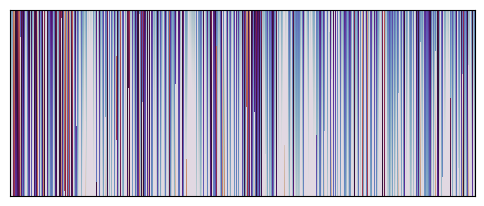

In [14]:
initial_row = sample[0: 500].to_numpy()
row_to_scale = initial_row.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_row = scaler.fit_transform(row_to_scale)
normalized_row = scaled_row.flatten()
stat = profile.stats["median"] 

single_row_mutations = genomic_sample_row_mutation(
    normalized_row, 
    200, 
    stat,
    decay_scale=0.00075,
    mutation_frequency = 5,
    mutation_intensity = profile.stats["std"],
    filename="single_row_mutation_median_decay_v1.png",
    cmap="twilight",
    plot=True,
    save=True,
    results_dir="results"
)
